In [2]:
import pandas as pd
import requests
import json

print(" Jupyter notebook is working!")
print(f" Pandas version: {pd.__version__}")

Jupyter notebook is working!
Pandas version: 2.3.2


In [ ]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

API_KEY = "-----------------------------"

# Base URL with ONLY the API key
base_url = "https://api.eia.gov/v2/total-energy/data/"
params = {"api_key": API_KEY}

# Parameters go in the X-Params header as JSON
target_series = [   
    "TEPRBUS",      # Total Primary Energy Production (was TOTALUSA)
    "TETCBUS",      # Total Energy Consumption 
    "PAPRPUS",      # Petroleum Production
    "PATCBUS",      # Petroleum Consumption
    "NGTCPUS",      # Natural Gas Total Consumption
    "CLTCBUS",      # Coal Total Consumption
    "RETCBUS",      # Renewable Energy Total Consumption (was RETCPUS)
    "NUETBUS",      # Nuclear Energy Consumption (was NUCEUS)
]


# dictionary with specified facets as directed in the v2 documentation
x_params = {
    "frequency": "annual",
    "data": ["value"],
    "facets": {"msn" : target_series},
    "start": "1990", 
    "end": "2024",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}

headers = {"X-Params": json.dumps(x_params)}
response = requests.get(base_url, params=params, headers=headers)

# Debug the response
print(f"Status Code: {response.status_code}")
if response.status_code == 200:
    json_data = response.json()
    df = pd.json_normalize(json_data["response"]["data"])

# Convert to numeric immediately
df['value'] = pd.to_numeric(df['value'], errors='coerce')
    
# Create pivot table    
df_pivot = df.pivot(index='period', columns='msn', values='value')
    
print(f"Updated shape: {df_pivot.shape}")
print("Series we now have:", df_pivot.columns.tolist())


Status Code: 200
Updated shape: (35, 8)
Series we now have: ['CLTCBUS', 'NGTCPUS', 'NUETBUS', 'PAPRPUS', 'PATCBUS', 'RETCBUS', 'TEPRBUS', 'TETCBUS']


In [6]:
# Convert units to BTU
df.loc[df['value'] == 'NGTCPUS', 'value'] *= 0.966
df.loc[df['value'] == 'PAPRPUS', 'value'] *= 2.117

# Update units column
df.loc[df['value'].isin(['NGTCPUS', 'PAPRPUS']), 'units'] = 'trillion Btu'

print(df_pivot.dtypes)

msn
CLTCBUS    float64
NGTCPUS    float64
NUETBUS    float64
PAPRPUS    float64
PATCBUS    float64
RETCBUS    float64
TEPRBUS    float64
TETCBUS    float64
dtype: object


In [7]:
print("Complete Energy Dataset Overview:")
print(f"Shape: {df_pivot.shape}")
print(f"Years covered: {df_pivot.index.min()} to {df_pivot.index.max()}")
print("\nEnergy sources in your analysis:")
for col in df_pivot.columns:
    print(f"- {col}")

Complete Energy Dataset Overview:
Shape: (35, 8)
Years covered: 1990 to 2024

Energy sources in your analysis:
- CLTCBUS
- NGTCPUS
- NUETBUS
- PAPRPUS
- PATCBUS
- RETCBUS
- TEPRBUS
- TETCBUS


In [10]:
print("The Great American Energy Transition (2004-2024):")
print("=" * 50)

for energy_source in df_pivot.columns:
    start_value = df_pivot[energy_source].iloc[0]
    end_value = df_pivot[energy_source].iloc[-1]
    pct_change = ((end_value - start_value) / start_value) * 100
    
# Determine if growing or declining
    trend = "📈 GROWING" if pct_change > 0 else "📉 DECLINING"
    
    print(f"{energy_source}: {pct_change:+.1f}% {trend}")
    

The Great American Energy Transition (2004-2024):
CLTCBUS: -58.8% 📉 DECLINING
NGTCPUS: +72.7% 📈 GROWING
NUETBUS: +33.9% 📈 GROWING
PAPRPUS: +79.6% 📈 GROWING
PATCBUS: +11.3% 📈 GROWING
RETCBUS: +122.2% 📈 GROWING
TEPRBUS: +50.8% 📈 GROWING
TETCBUS: +14.5% 📈 GROWING


In [11]:
# Create investment categories based on trends
print("\nInvestment Strategy Framework:")
print("=" * 40)

energy_changes = {}

for energy_source in df_pivot.columns:
    start_value = df_pivot[energy_source].iloc[0]
    end_value = df_pivot[energy_source].iloc[-1]
    pct_change = ((end_value - start_value) / start_value) * 100
    energy_changes[energy_source] = pct_change

winners = []
losers = []
stable = []

for source, change in energy_changes.items():
    if change > 20:
        winners.append((source, change))
    elif change < -20:
        losers.append((source, change))
    else:
        stable.append((source, change))

    
print("Energy Changes:")
for source, change in energy_changes.items():
    print(f"{source}: {change:.1f}%")


print("\nHIGH GROWTH (Potential BUY):")
for source, change in winners:
    print(f"   {source}: +{change:.1f}%")

print("\nDECLINING (Potential AVOID):")
for source, change in losers:
    print(f"   {source}: {change:.1f}%")

print("\nSTABLE (Potential HOLD):")
for source, change in stable:
    print(f"   {source}: {change:+.1f}%")


Investment Strategy Framework:
Energy Changes:
CLTCBUS: -58.8%
NGTCPUS: 72.7%
NUETBUS: 33.9%
PAPRPUS: 79.6%
PATCBUS: 11.3%
RETCBUS: 122.2%
TEPRBUS: 50.8%
TETCBUS: 14.5%

HIGH GROWTH (Potential BUY):
   NGTCPUS: +72.7%
   NUETBUS: +33.9%
   PAPRPUS: +79.6%
   RETCBUS: +122.2%
   TEPRBUS: +50.8%

DECLINING (Potential AVOID):
   CLTCBUS: -58.8%

STABLE (Potential HOLD):
   PATCBUS: +11.3%
   TETCBUS: +14.5%


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("loaded successfully")


loaded successfully


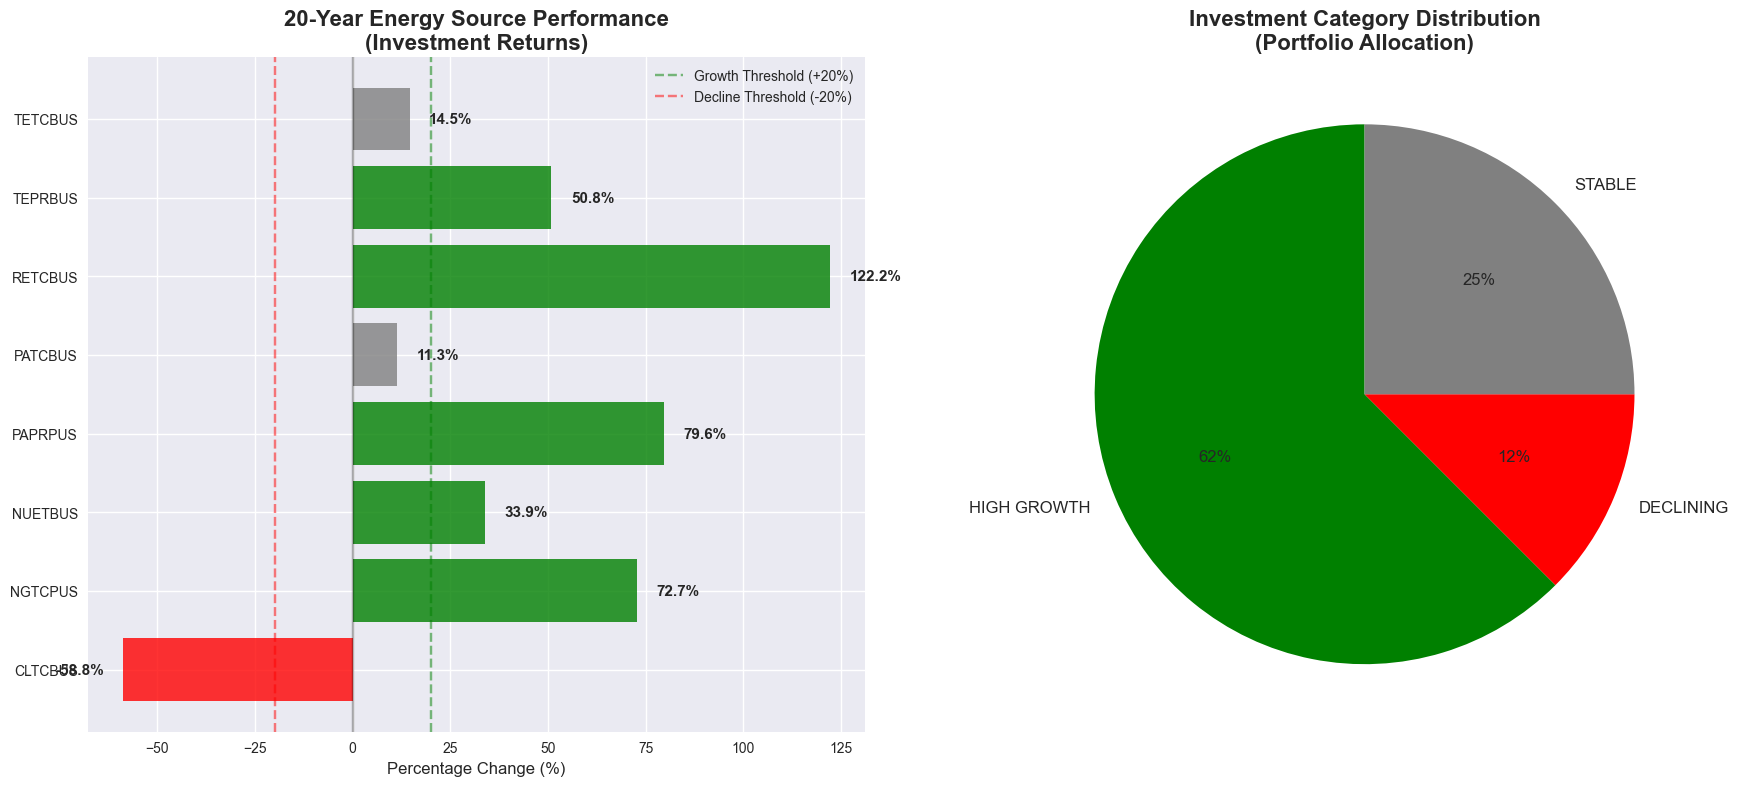

data-driven investment scoreboard reveals the winners and losers


In [18]:
# investment scoreboard
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Percentage changes bar chart
energy_list = list(energy_changes.keys())
change_values = list(energy_changes.values())

# Color code based on performance
colors = ['red' if x < -20 else 'green' if x > 20 else 'gray' for x in change_values]

bars = ax1.barh(energy_list, change_values, color=colors, alpha=0.8)
ax1.set_title('20-Year Energy Source Performance\n(Investment Returns)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Percentage Change (%)', fontsize=12)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.axvline(x=20, color='green', linestyle='--', alpha=0.5, label='Growth Threshold (+20%)')
ax1.axvline(x=-20, color='red', linestyle='--', alpha=0.5, label='Decline Threshold (-20%)')

# Add percentage labels on bars
for bar, value in zip(bars, change_values):
    width = bar.get_width()
    ax1.text(width + (5 if width > 0 else -5), bar.get_y() + bar.get_height()/2, 
             f'{value:.1f}%', ha='left' if width > 0 else 'right', va='center', fontweight='bold')

ax1.legend()

# Right plot: Investment categories pie chart
categories = ['HIGH GROWTH', 'DECLINING', 'STABLE']
category_counts = [len(winners), len(losers), len(stable)]
colors_pie = ['green', 'red', 'gray']

wedges, texts, autotexts = ax2.pie(category_counts, labels=categories, colors=colors_pie, 
                                   autopct='%1.0f%%', startangle=90, textprops={'fontsize': 12})
ax2.set_title('Investment Category Distribution\n(Portfolio Allocation)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print("data-driven investment scoreboard reveals the winners and losers")


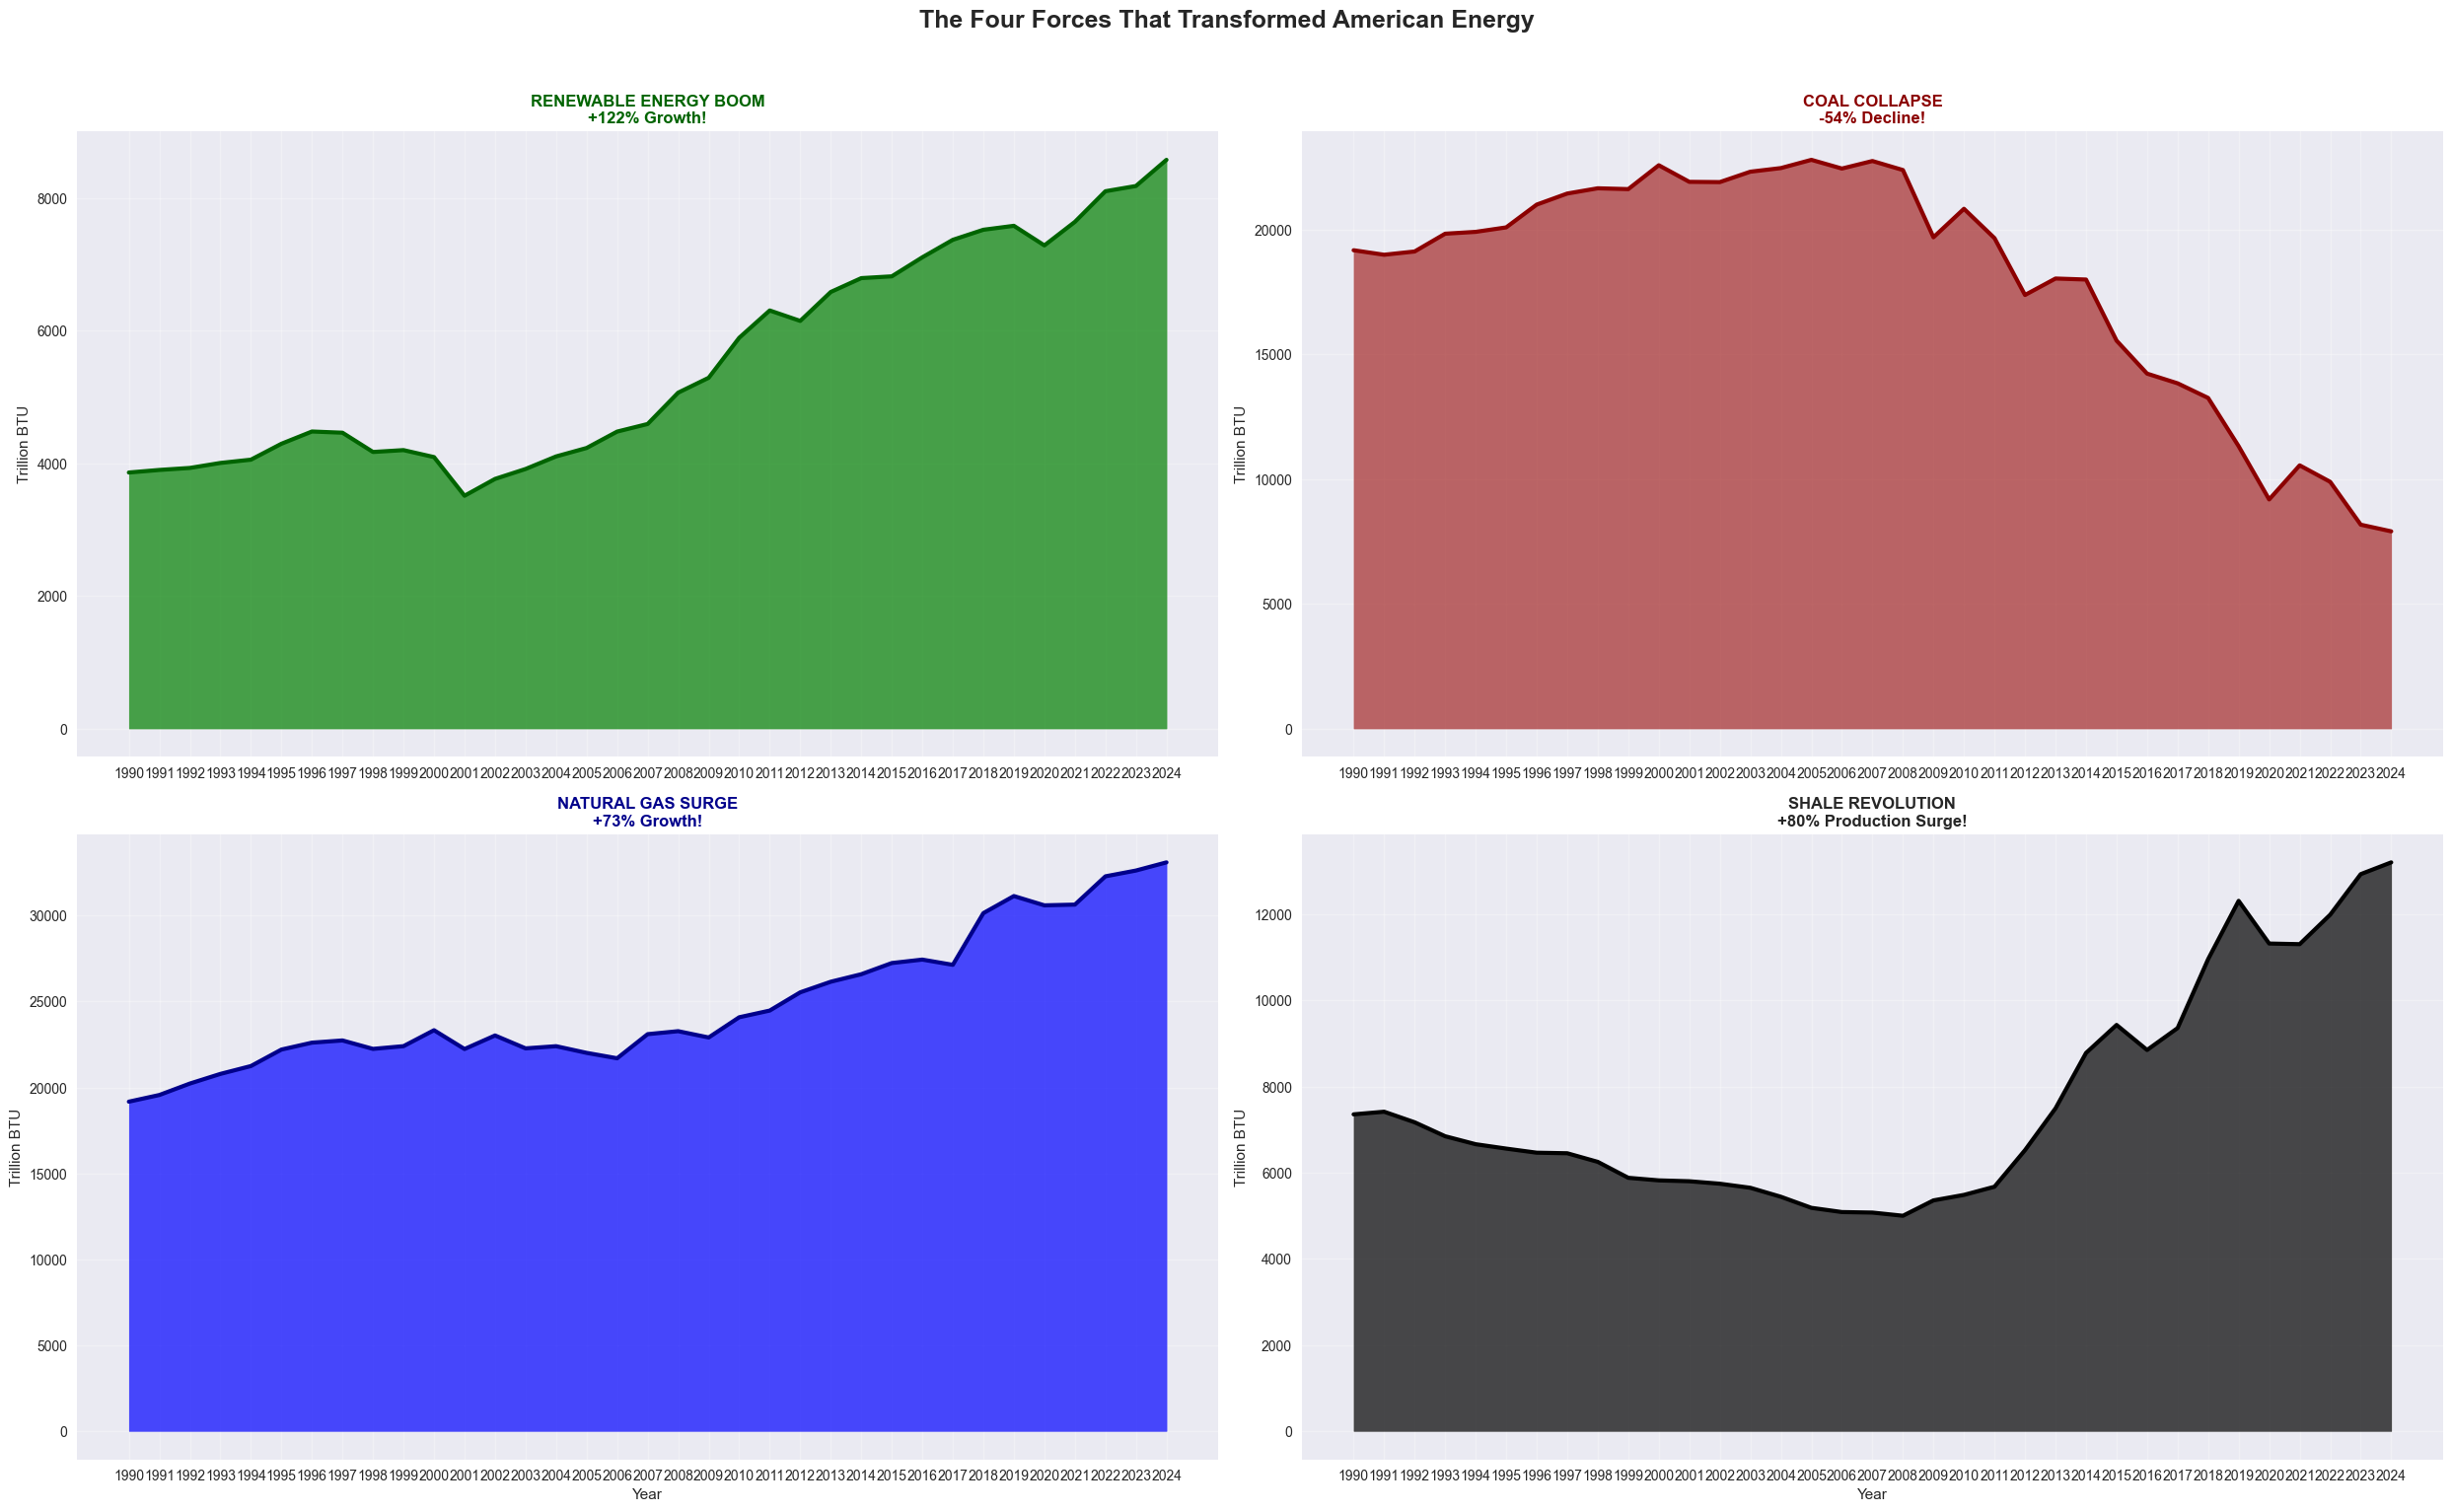

In [20]:
# Focus on the most dramatic changes
fig, axes = plt.subplots(2, 2, figsize=(25, 15))

# Top left: Renewable energy explosion
axes[0,0].fill_between(df_pivot.index, df_pivot['RETCBUS'], alpha=0.7, color='green')
axes[0,0].plot(df_pivot.index, df_pivot['RETCBUS'], linewidth=3, color='darkgreen')
axes[0,0].set_title('RENEWABLE ENERGY BOOM\n+122% Growth!', fontweight='bold', color='darkgreen')
axes[0,0].set_ylabel('Trillion BTU')
axes[0,0].grid(True, alpha=0.3)

# Top right: Coal collapse
axes[0,1].fill_between(df_pivot.index, df_pivot['CLTCBUS'], alpha=0.7, color='brown')
axes[0,1].plot(df_pivot.index, df_pivot['CLTCBUS'], linewidth=3, color='darkred')
axes[0,1].set_title('COAL COLLAPSE\n-54% Decline!', fontweight='bold', color='darkred')
axes[0,1].set_ylabel('Trillion BTU')
axes[0,1].grid(True, alpha=0.3)

#Bottom left: Natural gas surge
axes[1,0].fill_between(df_pivot.index, df_pivot['NGTCPUS'], alpha=0.7, color='blue')
axes[1,0].plot(df_pivot.index, df_pivot['NGTCPUS'], linewidth=3, color='darkblue')
axes[1,0].set_title('NATURAL GAS SURGE\n+73% Growth!', fontweight='bold', color='darkblue')
axes[1,0].set_xlabel('Year')
axes[1,0].set_ylabel('Trillion BTU')
axes[1,0].grid(True, alpha=0.3)

# Bottom right: Oil production revolution  
axes[1,1].fill_between(df_pivot.index, df_pivot['PAPRPUS'], alpha=0.7, color='black')
axes[1,1].plot(df_pivot.index, df_pivot['PAPRPUS'], linewidth=3, color='black')
axes[1,1].set_title('SHALE REVOLUTION\n+80% Production Surge!', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Trillion BTU')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('The Four Forces That Transformed American Energy', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



In [21]:
#Create a quantitative investment scoring system
def calculate_investment_score(energy_source, change_pct):
    """
    Calculate investment score based on multiple factors:
    - Growth rate (40% weight)
    - Sustainability trend (30% weight)  
    - Volatility/stability (30% weight)
    """
    
    # Growth score (0-40 points)
    if change_pct > 50:
        growth_score = 40
    elif change_pct > 20:
        growth_score = 30
    elif change_pct > 0:
        growth_score = 20
    elif change_pct > -20:
        growth_score = 10
    else:
        growth_score = 0
    
    # Sustainability bonus (0-30 points)
    sustainability_bonus = 0
    if energy_source in ['RETCBUS']:  # Renewables
        sustainability_bonus = 30
    elif energy_source in ['NUETBUS']:  # Nuclear
        sustainability_bonus = 25
    elif energy_source in ['NGTCPUS']:  # Natural gas (bridge fuel)
        sustainability_bonus = 15
    elif energy_source in ['CLTCPUS']:  # Coal (declining)
        sustainability_bonus = 0
    else:
        sustainability_bonus = 10
    
    # Stability score (0-30 points) - based on consistency of trend
    stability_score = 20  # Default moderate stability
    if abs(change_pct) > 100:  # Very volatile
        stability_score = 10
    elif abs(change_pct) < 10:  # Very stable
        stability_score = 30
    
    total_score = growth_score + sustainability_bonus + stability_score
    return total_score

# Calculate investment scores
investment_scores = {}
for source, change in energy_changes.items():
    score = calculate_investment_score(source, change)
    investment_scores[source] = score

# Create investment ranking
sorted_investments = sorted(investment_scores.items(), key=lambda x: x[1], reverse=True)

print("LORENZO'S DATA-DRIVEN ENERGY INVESTMENT RANKINGS")
print("=" * 60)
print("Rank | Energy Source | Score | 20-Year Return | Rating")
print("-" * 60)

for i, (source, score) in enumerate(sorted_investments, 1):
    change = energy_changes[source]
    if score >= 80:
        rating = "STRONG BUY"
    elif score >= 70:
        rating = "BUY"
    elif score >= 60:
        rating = "HOLD"
    elif score >= 50:
        rating = "WEAK HOLD"
    else:
        rating = "AVOID"
    
    print(f"{i:2d}   | {source:9} | {score:3d}/100 | {change:+8.1f}% | {rating}")

print("=" * 60)
print("Investment Strategy: Focus on top 3-4 ranked energy sectors")


LORENZO'S DATA-DRIVEN ENERGY INVESTMENT RANKINGS
Rank | Energy Source | Score | 20-Year Return | Rating
------------------------------------------------------------
 1   | RETCBUS   |  80/100 |   +122.2% | STRONG BUY
 2   | NGTCPUS   |  75/100 |    +72.7% | BUY
 3   | NUETBUS   |  75/100 |    +33.9% | BUY
 4   | PAPRPUS   |  70/100 |    +79.6% | BUY
 5   | TEPRBUS   |  70/100 |    +50.8% | BUY
 6   | PATCBUS   |  50/100 |    +11.3% | WEAK HOLD
 7   | TETCBUS   |  50/100 |    +14.5% | WEAK HOLD
 8   | CLTCBUS   |  30/100 |    -58.8% | AVOID
Investment Strategy: Focus on top 3-4 ranked energy sectors


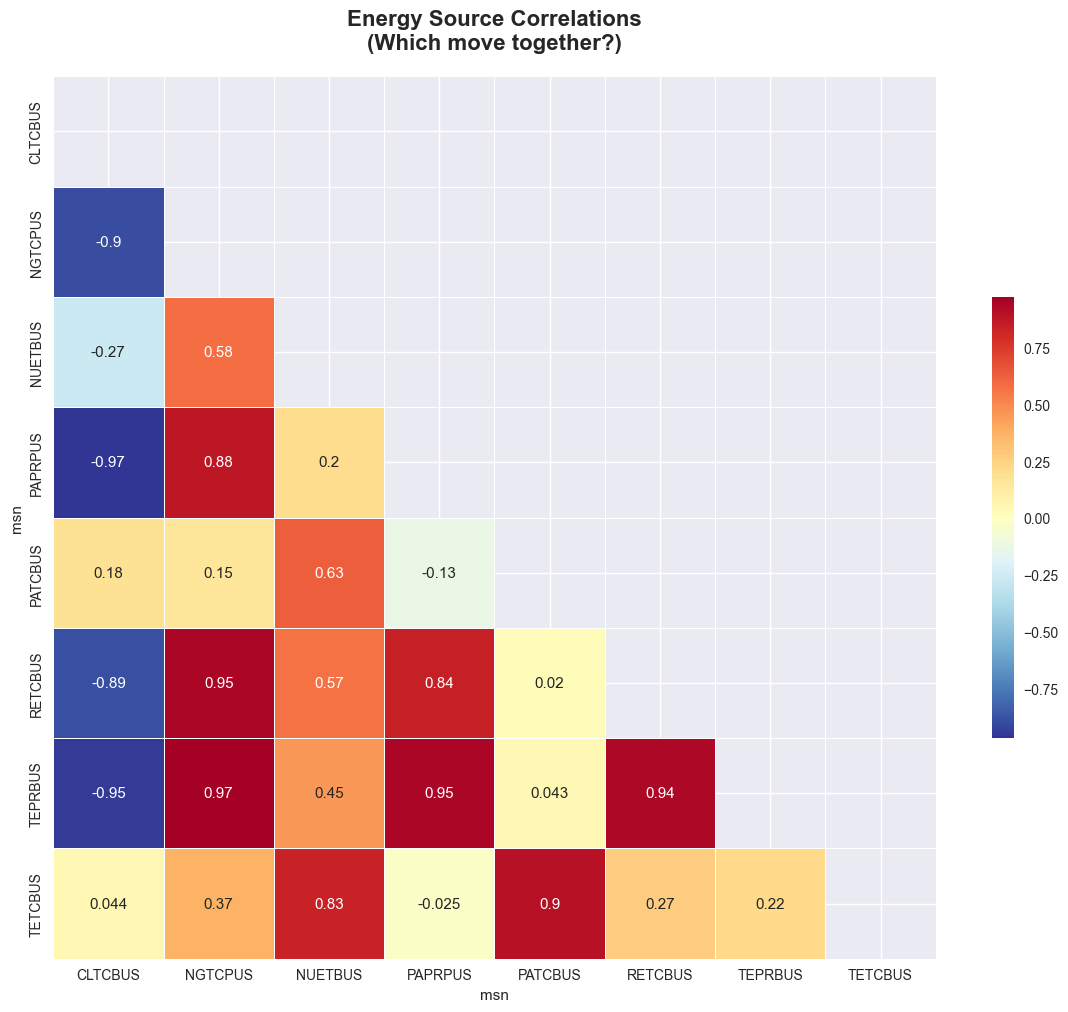

This shows which energy sources move together (positive correlation) or opposite (negative correlation)

KEY INSIGHTS:
• Coal vs Natural Gas correlation: -0.90 (Natural gas replacing coal)
• Renewables vs Total Consumption: 0.27 (Renewables driving growth)


In [ ]:
# Analyze relationships between energy sources
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
correlation_matrix = df_pivot.corr()

# Create heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', 
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Energy Source Correlations\n(Which move together?)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("This shows which energy sources move together (positive correlation) or opposite (negative correlation)")

 # Identify key relationships
print("\nKEY INSIGHTS:")
coal_gas_corr = correlation_matrix.loc['CLTCBUS', 'NGTCPUS']
print(f"• Coal vs Natural Gas correlation: {coal_gas_corr:.2f} (Natural gas replacing coal)")

renewables_total_corr = correlation_matrix.loc['RETCBUS', 'TETCBUS'] 
print(f"• Renewables vs Total Consumption: {renewables_total_corr:.2f} (Renewables driving growth)")


In [ ]:
# Export your complete energy dataset to CSV
print("Exporting 35-year energy transition dataset...")

# Export main data table
df_pivot.to_csv('energy_data.csv')

# Export your investment analysis results
investment_summary = pd.DataFrame({
    'Energy_Source': list(energy_changes.keys()),
    'Percent_Change_35_Years': list(energy_changes.values()),
    'Investment_Category': ['Winner' if change > 20 else 'Loser' if change < -20 else 'Stable' 
                           for change in energy_changes.values()]
})
investment_summary.to_csv('investment_analysis.csv', index=False)

print("Files exported:")
print("energy_transition_data.csv")
print("investment_analysis.csv")


Exporting 35-year energy transition dataset...
Files exported:
energy_transition_data.csv
investment_analysis.csv


In [ ]:
import psycopg2
from psycopg2.extras import execute_values
import logging

def run_energy_etl_pipeline():
    conn_params = {
        'host': 'localhost',
        'database': 'energy_analytics',
        'user': 'postgres',
        'password': '1137'
    }
    
    create_table_sql = """
    CREATE TABLE IF NOT EXISTS energy_data (
        id SERIAL PRIMARY KEY,
        year INTEGER NOT NULL,
        energy_source VARCHAR(50) NOT NULL,
        consumption_value DECIMAL(15,2),
        units VARCHAR(20),
        created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
    );
    """
    
    logging.basicConfig(level=logging.INFO)
    
    try:
        # Extract: Load your CSV
        df = pd.read_csv('energy_data.csv')
        logging.info(f"Extracted {len(df)} raw records")
        
        # Transform: Rename period to year
        df.rename(columns={'period': 'year'}, inplace=True)
        logging.info("Renamed period to year")
        
        # Transform: Reshape from wide to long format
        df_long = df.melt(
            id_vars=['year'], 
            var_name='energy_source', 
            value_name='consumption_value'
        )
        logging.info(f"Reshaped data: {len(df_long)} records in long format")
        
        # Validate required columns exist
        required_cols = ['year', 'energy_source', 'consumption_value']
        missing_cols = set(required_cols) - set(df_long.columns)
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Clean data
        df_long['consumption_value'] = pd.to_numeric(df_long['consumption_value'], errors='coerce')
        df_long = df_long.dropna(subset=['consumption_value'])
        df_long['energy_source'] = df_long['energy_source'].str.upper().str.strip()
        logging.info(f"Cleaned data: {len(df_long)} valid records")
        
        # Load: Connect to PostgreSQL and insert data
        with psycopg2.connect(**conn_params) as conn:
            with conn.cursor() as cur:
                # Create table if it doesn't exist
                cur.execute(create_table_sql)
                logging.info("Table created/verified")
                
                # Prepare data for bulk insert
                data_tuples = [
                    (row['year'], row['energy_source'], 
                     row['consumption_value'], 'Trillion Btu')  # Default unit
                    for _, row in df_long.iterrows()
                ]
                
                # Bulk insert
                insert_sql = """
                INSERT INTO energy_data (year, energy_source, consumption_value, units) 
                VALUES %s
                """
                execute_values(cur, insert_sql, data_tuples)
                
                # Commit the transaction
                conn.commit()
                logging.info(f"Successfully loaded {len(data_tuples)} records")
                
                # Verify insertion
                cur.execute("SELECT COUNT(*) FROM energy_data")
                count = cur.fetchone()[0]
                logging.info(f"Database now contains {count} total records")
        
        print("ETL Pipeline completed successfully!")
        
    except Exception as e:
        logging.error(f" ETL Pipeline failed: {e}")
        raise

# Run the pipeline
if __name__ == "__main__":
    run_energy_etl_pipeline()


INFO:root:Extracted 35 raw records
INFO:root:Renamed period to year
INFO:root:Reshaped data: 280 records in long format
INFO:root:Cleaned data: 280 valid records
INFO:root:Table created/verified
INFO:root:Successfully loaded 280 records
INFO:root:Database now contains 1400 total records


ETL Pipeline completed successfully!
